In [376]:
import pandas as pd 
import os
import re
from collections import Counter

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import numpy as np

import chart_studio.plotly as py
import plotly.graph_objects as go
import cufflinks as cf 
cf.go_offline(connected=True)
import plotly.express as px

In [366]:
DATA_PATH = "data"

In [23]:
train_filepath = os.path.join(DATA_PATH, "train.csv")
val_filepath = os.path.join(DATA_PATH, "validation.csv")


In [24]:
train_df = pd.read_csv(train_filepath)
val_df = pd.read_csv(val_filepath)

number_of_trainset = len(train_df)
number_of_validationset = len(val_df)

all_df = pd.concat([train_df, val_df]).reset_index(drop=True)

/Users/sungchulchoi/miniconda3/envs/python_ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (8,172,173,174,175,176,177,178,179) have mixed types.Specify dtype option on import or set low_memory=False.



# 데이터셋의 imbalanced 성향 확인

In [32]:
all_df["fr_yn"].value_counts().iplot(kind="bar")

In [35]:
pd.options.display.max_rows = 999
all_df.head(1).T

0
dt_of_fr                      2017-10-20 05:54
fr_yn                                        Y
bldng_us                                  단독주택
bldng_archtctr                            블록구조
bldng_cnt                                    3
bldng_ar                                 69.42
ttl_ar                                   69.42
lnd_ar                                       0
dt_of_athrztn                             1977
ttl_grnd_flr                                 1
ttl_dwn_flr                                  0
bldng_us_clssfctn                          주거용
tmprtr                                    10.7
prcpttn                                    NaN
wnd_spd                                    0.9
wnd_drctn                                  200
hmdt                                        96
gas_engry_us_201401                          0
ele_engry_us_201401                          0
gas_engry_us_201402                          0
ele_engry_us_201402                          0
gas_engry_us_201403                          0
ele_engry_us_201403                          0
gas_engry_us_201404                          0
ele_engry_us_201404                          0
gas_engry_us_201405                          0
ele_engry_us_201405                          0
gas_engry_us_201406                          0
ele_engry_us_201406                          0
gas_engry_us_201407                          0
ele_engry_us_201407                          0
gas_engry_us_201408                          0
ele_engry_us_201408                          0
gas_engry_us_201409                          0
ele_engry_us_201409                          0
gas_engry_us_201410                          0
ele_engry_us_201410                          0
gas_engry_us_201411                          0
ele_engry_us_201411                          0
gas_engry_us_201412                          0
ele_engry_us_201412                          0
gas_engry_us_201501                          0
ele_engry_us_201501                          0
gas_engry_us_201502                          0
ele_engry_us_201502                          0
gas_engry_us_201503                          0
ele_engry_us_201503                          0
gas_engry_us_201504                          0
ele_engry_us_201504                          0
gas_engry_us_201505                          0
ele_engry_us_201505                          0
gas_engry_us_201506                          0
ele_engry_us_201506                          0
gas_engry_us_201507                          0
ele_engry_us_201507                          0
gas_engry_us_201508                          0
ele_engry_us_201508                          0
gas_engry_us_201509                          0
ele_engry_us_201509                          0
gas_engry_us_201510                          0
ele_engry_us_201510                          0
gas_engry_us_201511                          0
ele_engry_us_201511                          0
gas_engry_us_201512                          0
ele_engry_us_201512                          0
gas_engry_us_201601                          0
ele_engry_us_201601                          0
gas_engry_us_201602                          0
ele_engry_us_201602                          0
gas_engry_us_201603                          0
ele_engry_us_201603                          0
gas_engry_us_201604                          0
ele_engry_us_201604                          0
gas_engry_us_201605                          0
ele_engry_us_201605                          0
gas_engry_us_201606                          0
ele_engry_us_201606                          0
gas_engry_us_201607                          0
ele_engry_us_201607                          0
gas_engry_us_201608                          0
ele_engry_us_201608                          0
gas_engry_us_201609                          0
ele_engry_us_201609                          0
gas_engry_us_201610                          0
ele_engry_us_201610                          0
gas

# 따로 빼줘야 하는 데이터들

- gas_engry_us_201401
- ele_engry_us_201403
- lw_13141011


In [45]:
gas_engry_col_names = [col_name for col_name in all_df.columns.tolist() if "gas_engry_us" in col_name ]
ele_engry_col_names = [col_name for col_name in all_df.columns.tolist() if "ele_engry_us" in col_name ]
lw_col_names = [col_name for col_name in all_df.columns.tolist() if "lw" in col_name ]


In [57]:
gas_engry_df = all_df[gas_engry_col_names]
ele_engry_df = all_df[ele_engry_col_names]
lw_df = all_df[lw_col_names]
main_df = all_df.drop(gas_engry_col_names+ele_engry_col_names+lw_col_names,axis=1)

## 분석가설
1. 시간이 화재 발생에 영향을 줄까?
2. 주택의 종류가 화재 발생에 영향을 줄까?



In [59]:
main_df["dt_of_fr"] = pd.to_datetime(main_df["dt_of_fr"])

In [62]:
main_df.rename(columns={"id":"아이디",
  "bldng_us":"건물용도",
  "bldng_archtctr":"건물구조",
  "bldng_cnt":"건물채수",
  "bldng_ar":"건물건축면적",
  "ttl_ar":"건물층별합계전체면적",
  "lnd_ar":"토지면적" ,
  "dt_of_athrztn":"건물승인일자" ,
  "ttl_grnd_flr":"건물들지상층수합" ,
  "ttl_dwn_flr":"건물들지하층수합",
  "bldng_us_clssfctn":"건물용도분류명",
  "tmprtr":"온도",
  "prcpttn":"강수량",
  "wnd_spd":"풍속" ,	
   "wnd_drctn":"풍향",	
  "hmdt":"습도",
  "jmk":"지적상지목",
   "rgnl_ar_nm":"용도지역지구명",
  "rgnl_ar_nm2":"용도지역지구명2",
  "lnd_us_sttn_nm":"토지이용상황명",
   "rd_sd_nm":"도로측면명",
   "emd_nm":"행정구역명",	
   "hm_cnt":"행정구역인구",	
   "fr_sttn_dstnc":"소방서거리",
   "bldng_ar_prc":"건물면적당가격",
   "fr_wthr_fclt_dstnc":"소방용수시설거리",	
   "fr_mn_cnt":"관할소방서인원",	
   "mlt_us_yn":"다중이용시설여부",
   "cctv_dstnc":"공공CCTV거리"	,
   "cctv_in_100m":"백미터이내CCTV수",	
   "fr_wthr_fclt_in_100m":"백미터이내소방용수시설수"	,
   "tbc_rtl_str_dstnc":"담배소매점거리",
   "sft_emrgnc_bll_dstnc":"안전비상벨최소거리",
   "ahsm_dstnc":"자동심장충격기거리",	
   "no_tbc_zn_dstnc":"금연구역최소거리",	
   "bldng_cnt_in_50m":"반경50m건물수",
   "fr_yn":"화재발생",
   "trgt_crtr":"소방점검대상물기준",
   "fr_fghtng_fclt_spcl_css_5_yn":"소방시설특례5호여부",
   "fr_fghtng_fclt_spcl_css_6_yn":"소방시설특례6호여부",
   "us_yn":"사용여부",
   "dngrs_thng_yn":"위험물대상여부",
   "slf_fr_brgd_yn":"자체소방대여부",
   "blk_dngrs_thng_mnfctr_yn":"대량위험물제조소등여부",
   "cltrl_hrtg_yn":"문화재여부"}, inplace=True)

In [ ]:
main_df.head(1).T

In [77]:
numeric_col_names = ["건물채수", "건물건축면적", "건물층별합계전체면적", "토지면적", "건물들지상층수합", "건물들지하층수합", 
"온도", "강수량", "풍속", "풍향", "습도", "행정구역인구", "소방용수시설거리", "관할소방서인원", "공공CCTV거리", 
"담배소매점거리", "안전비상벨최소거리", "자동심장충격기거리", "금연구역최소거리", "반경50m건물수", "건물면적당가격"]
object_col_names = [
"건물용도", "건물구조", "건물용도분류명", "지적상지목", "용도지역지구명", "용도지역지구명2", "토지이용상황명","행정구역명","소방점검대상물기준", 
"소방시설특례5호여부", "소방시설특례6호여부", "사용여부", "위험물대상여부", "자체소방대여부", "대량위험물제조소등여부", "문화재여부"
]

In [83]:
main_df["화재발생"] = main_df["화재발생"].replace({"Y":1 , "N":0})

In [84]:
#mac 용 한글 폰트 처리 코드
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

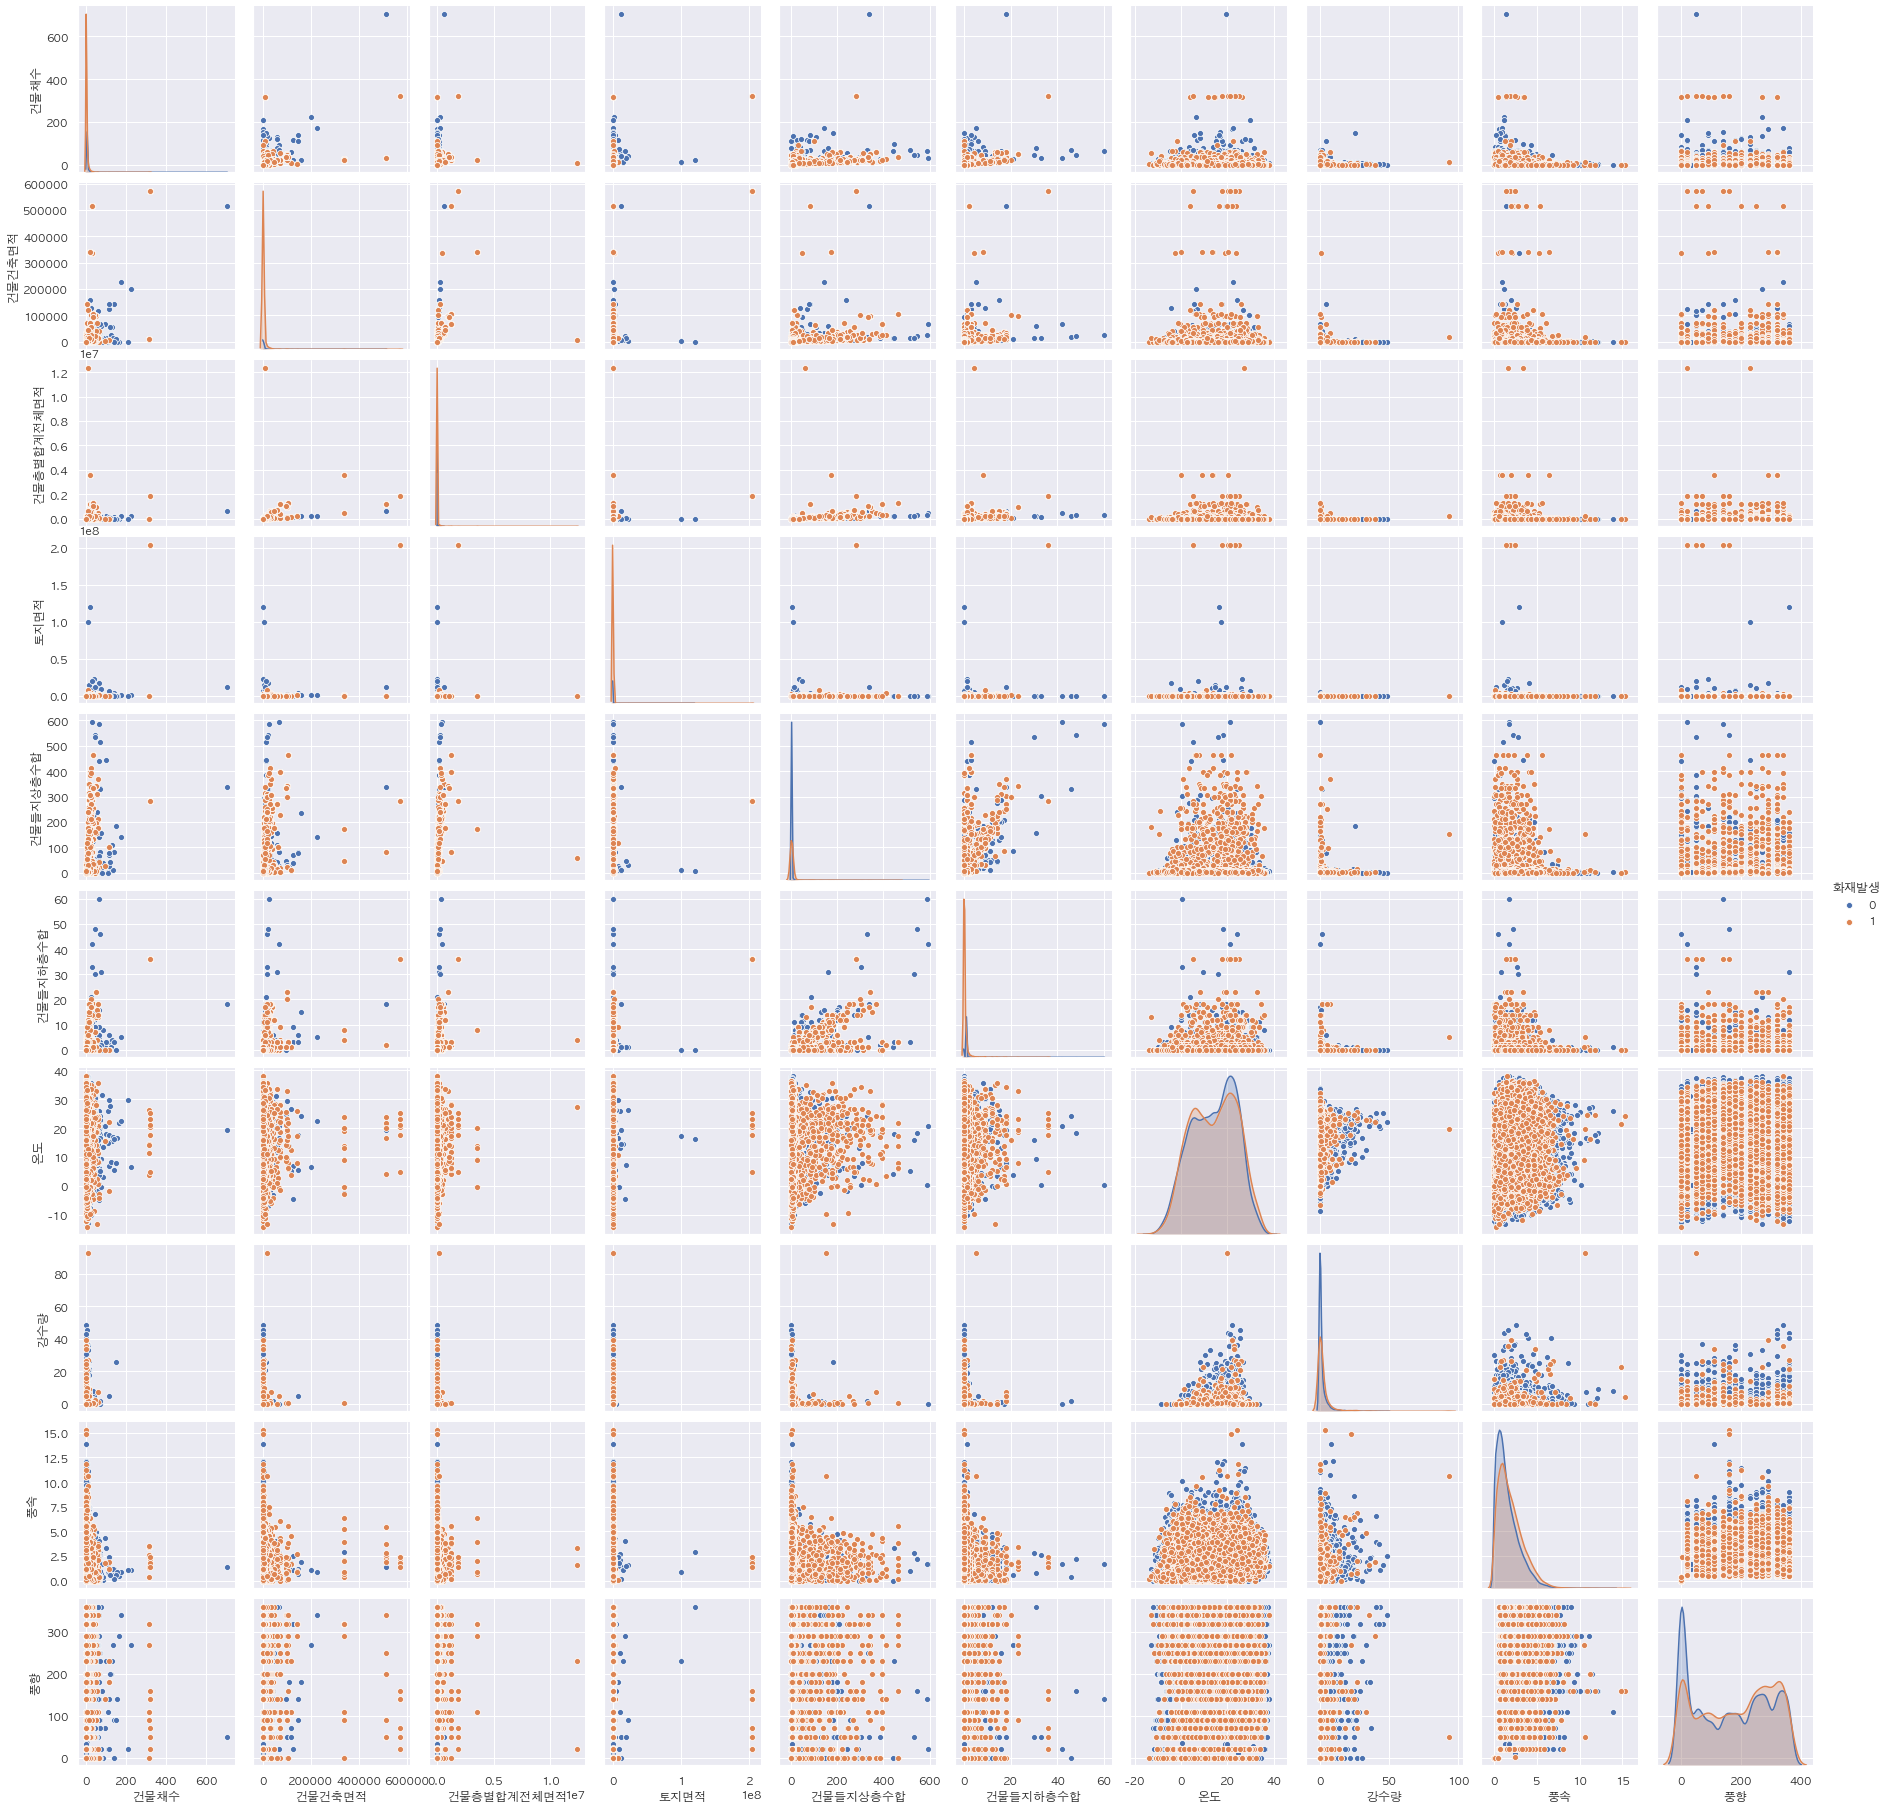

In [85]:
g = sns.pairplot(main_df[numeric_col_names[:5]+["화재발생"]],  hue="화재발생")

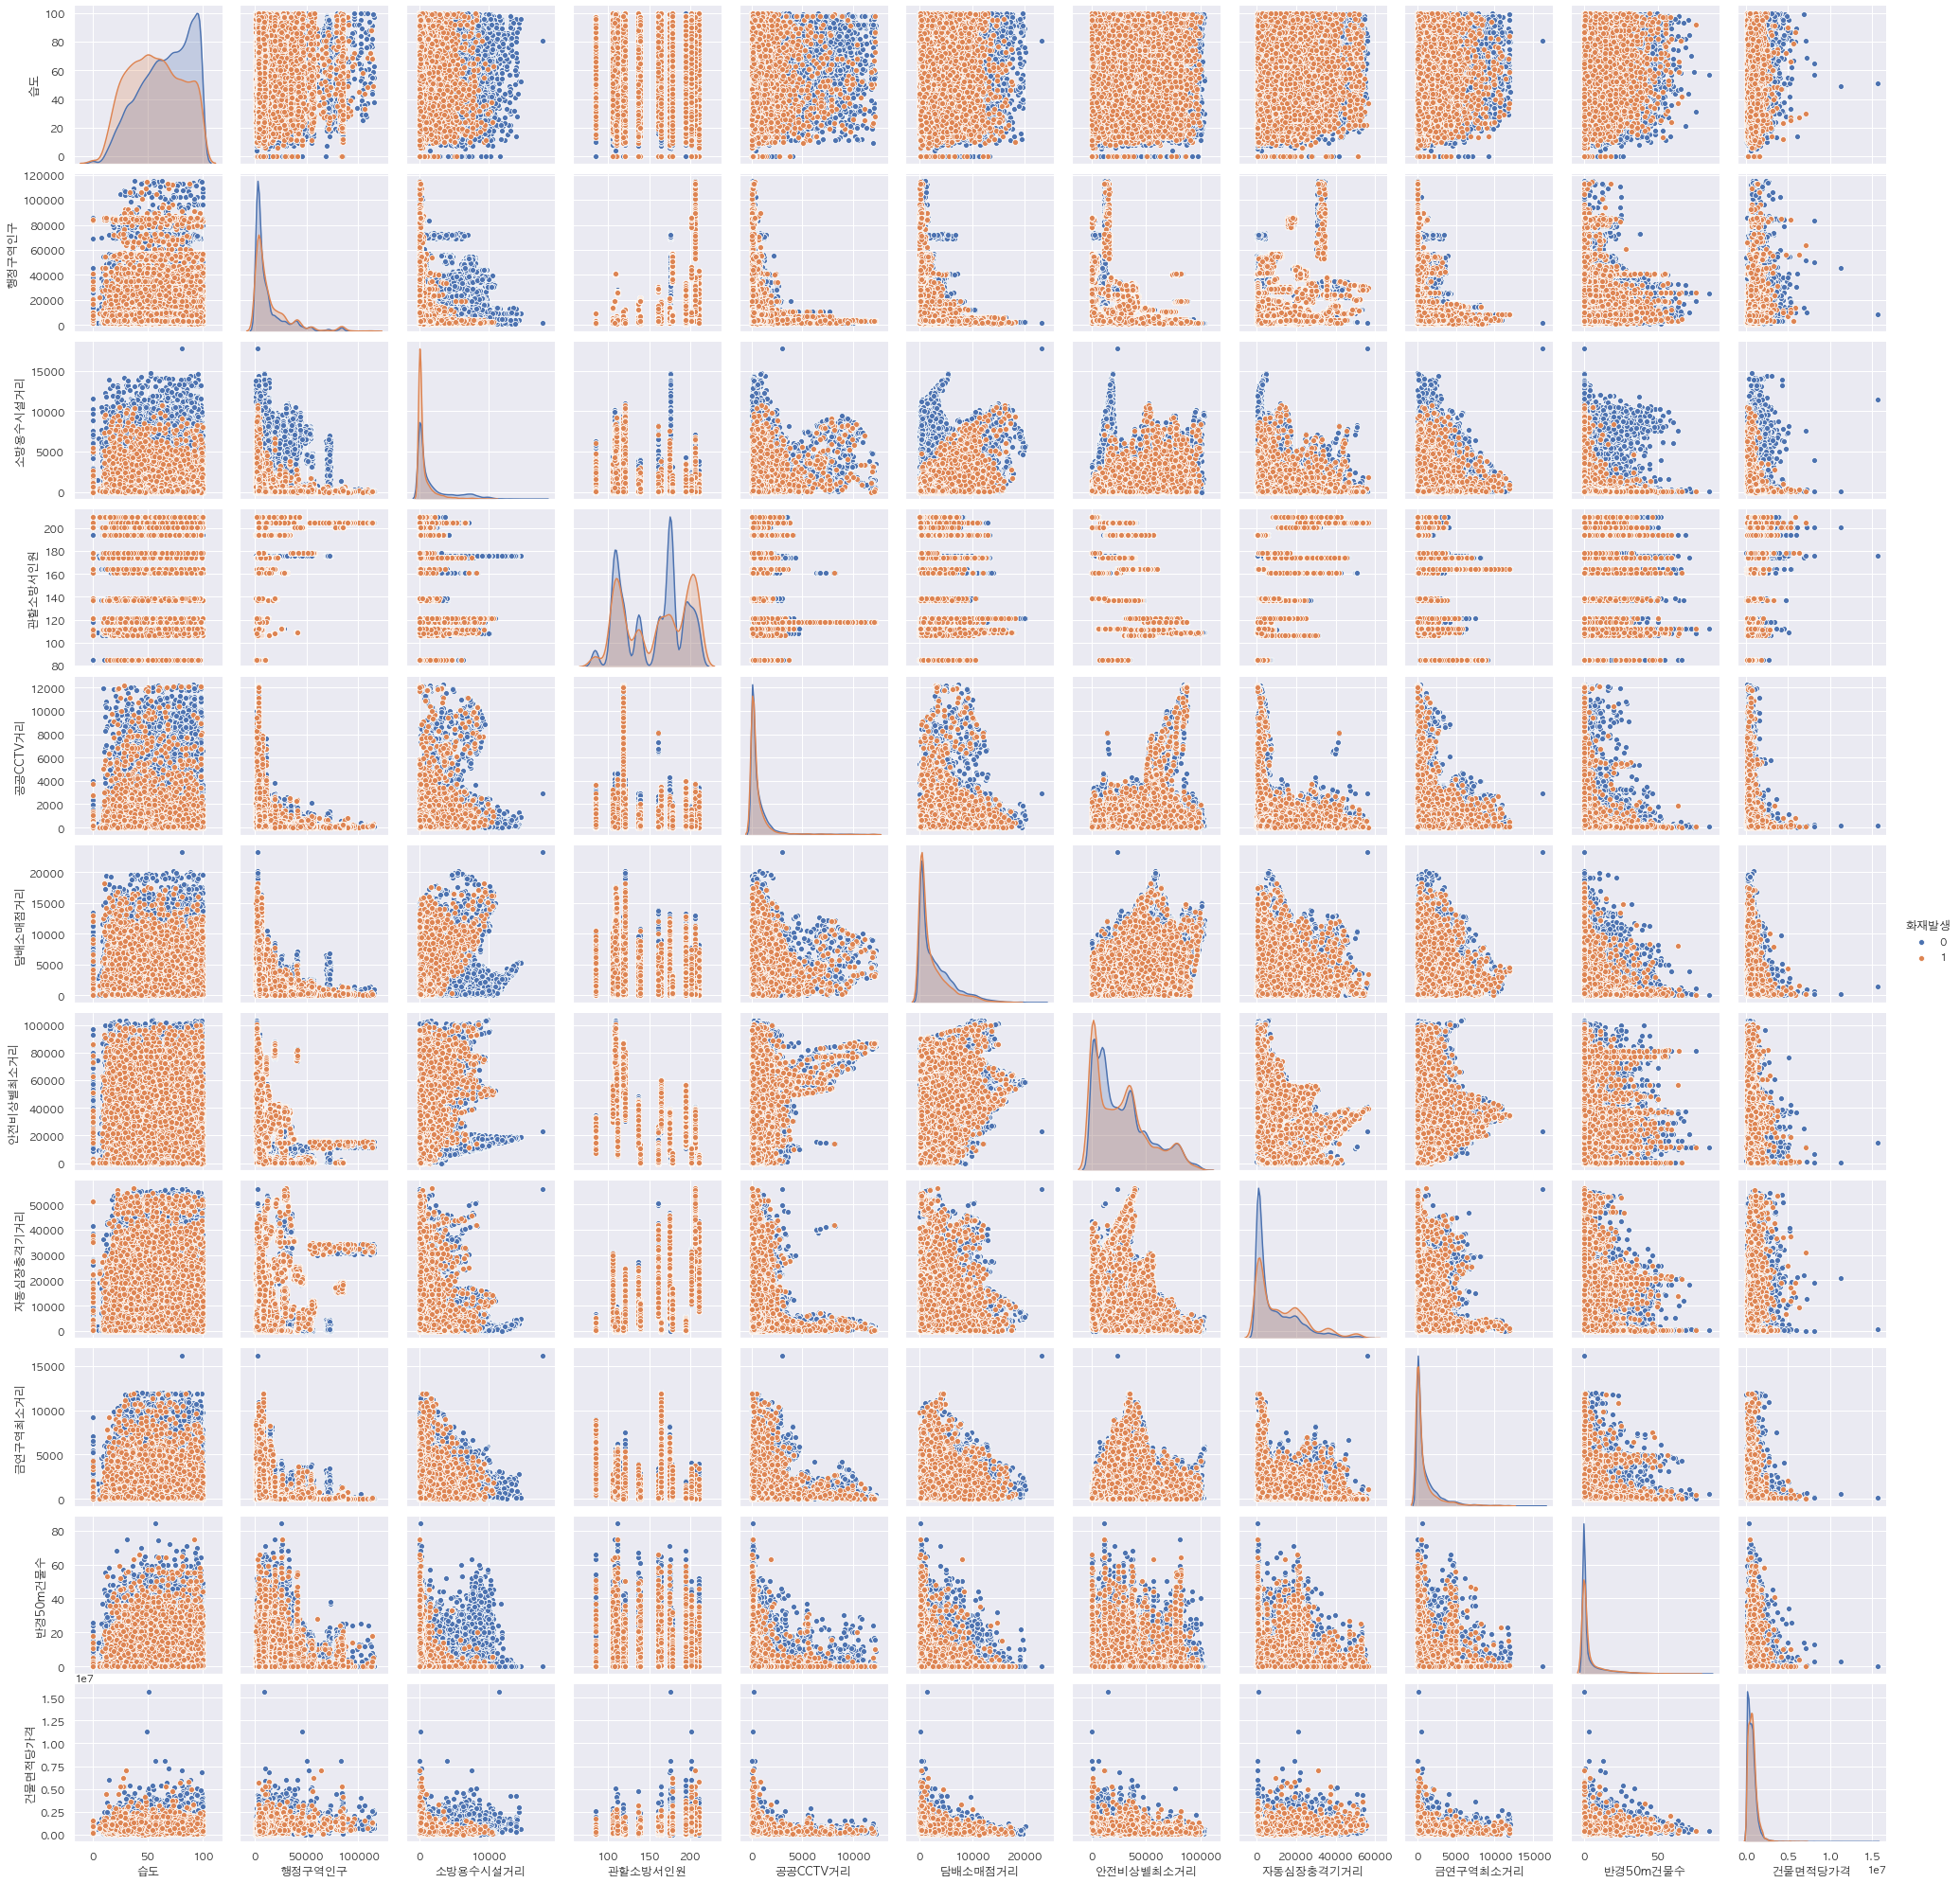

In [86]:
g = sns.pairplot(main_df[numeric_col_names[10:]+["화재발생"]],  hue="화재발생")

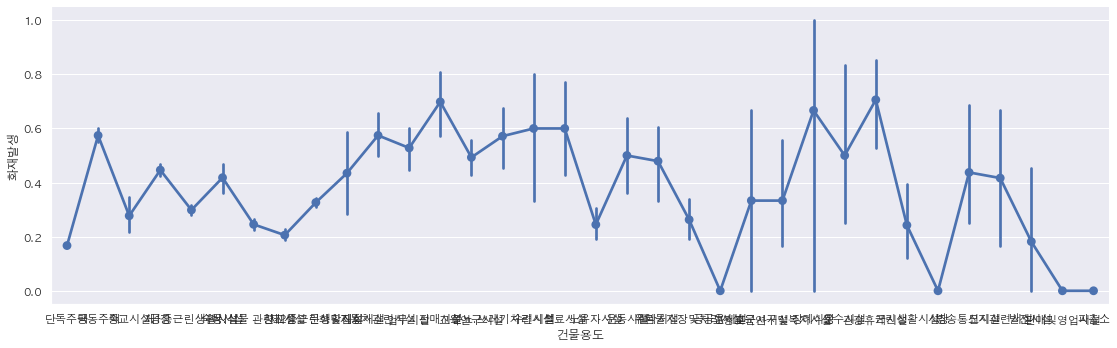

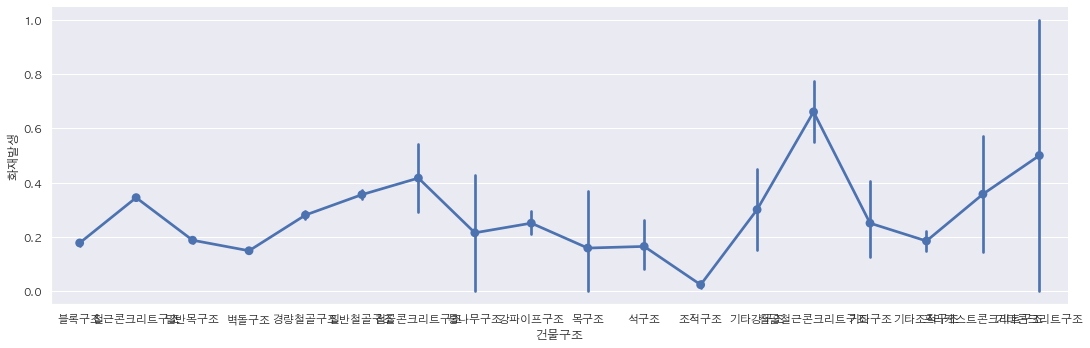

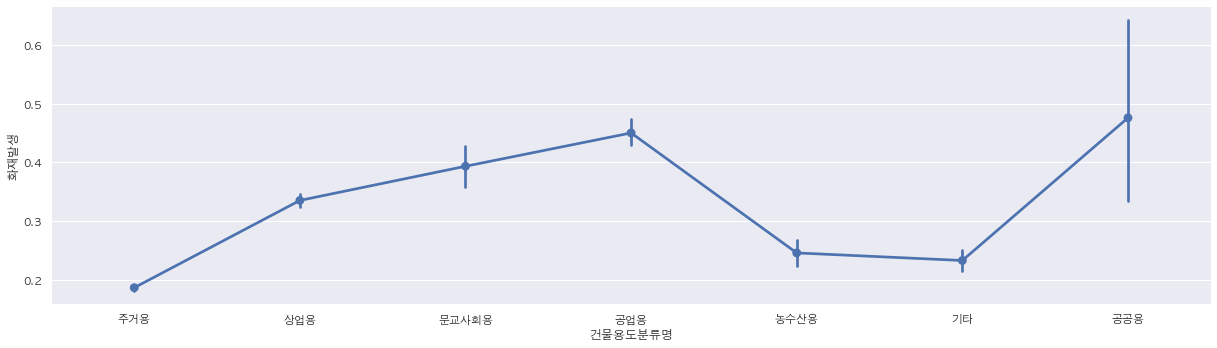

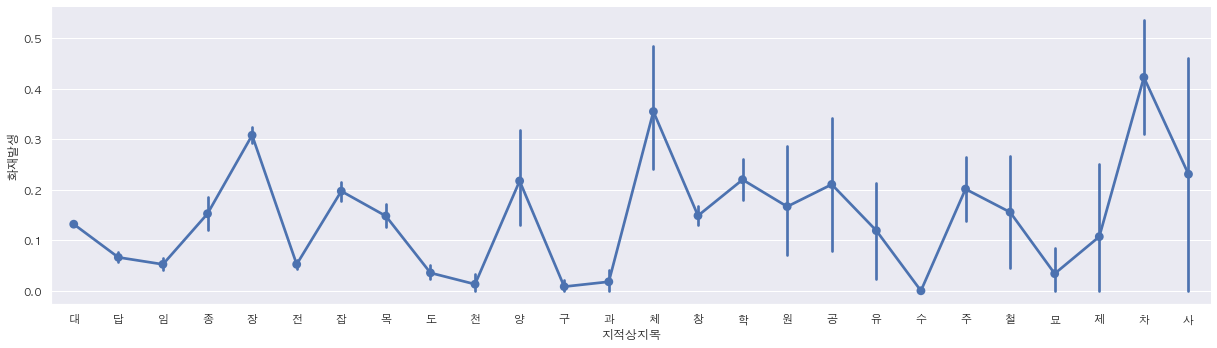

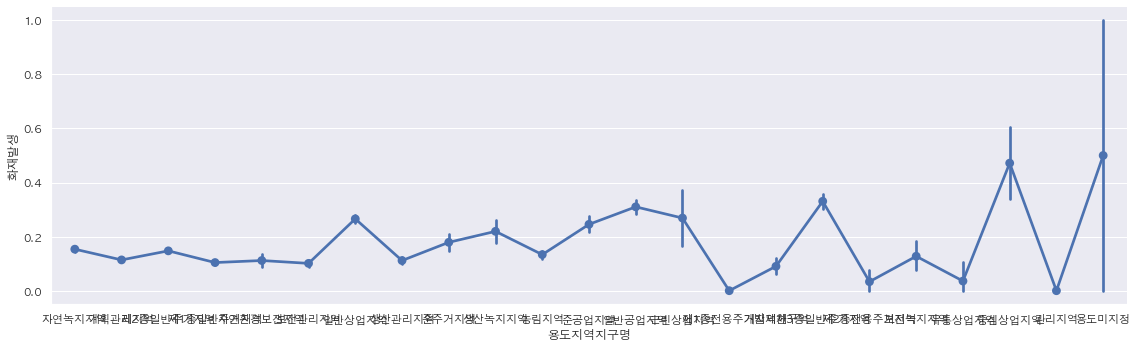

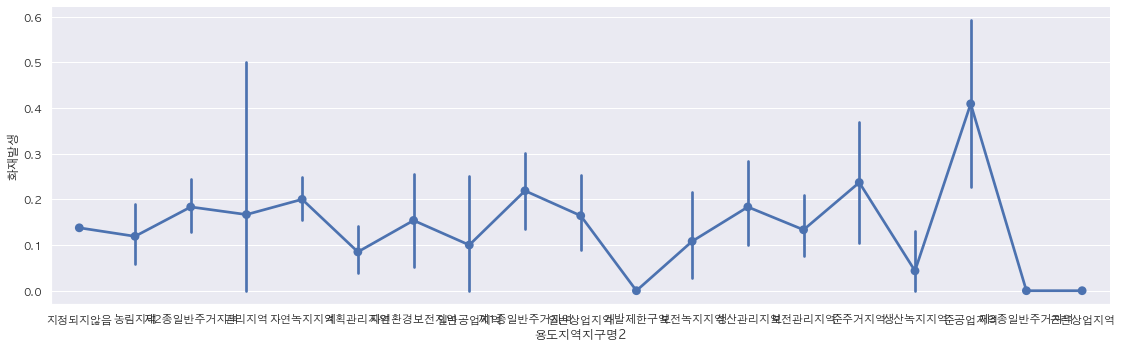

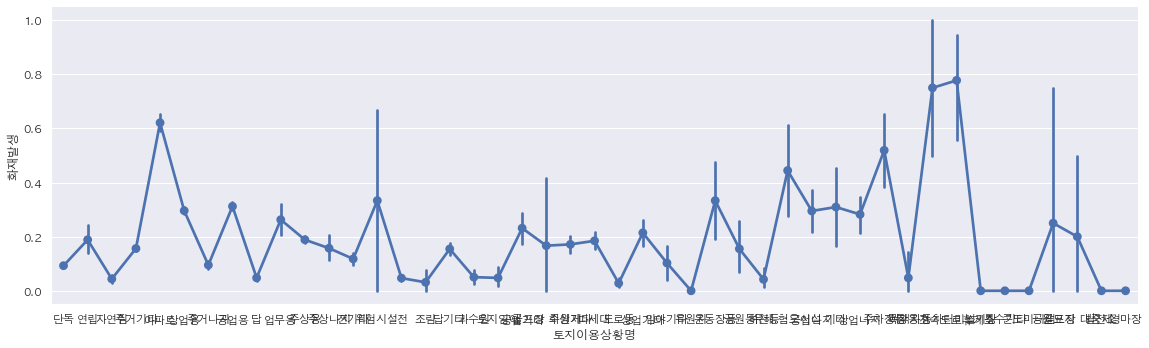

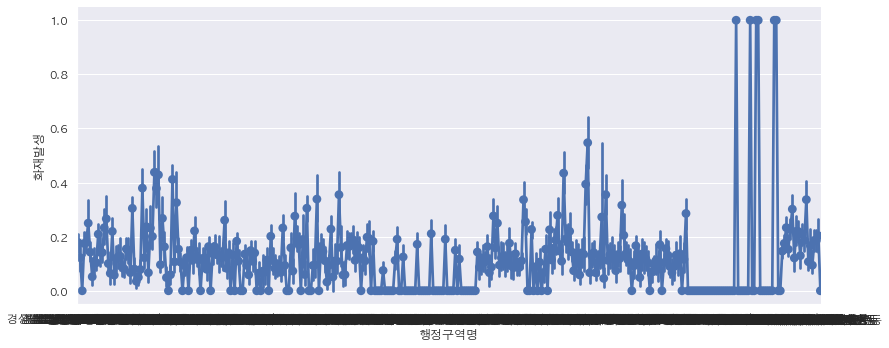

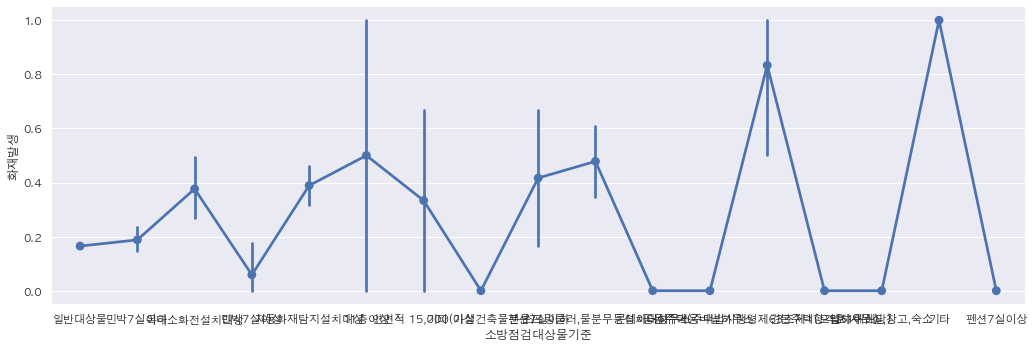

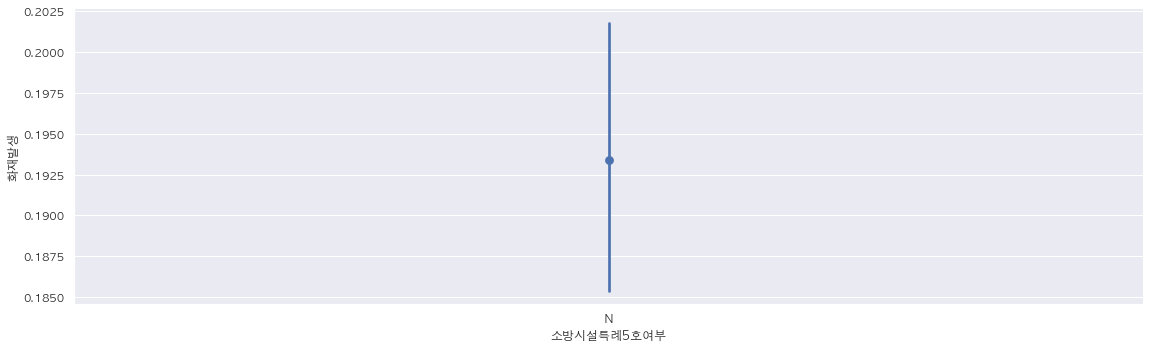

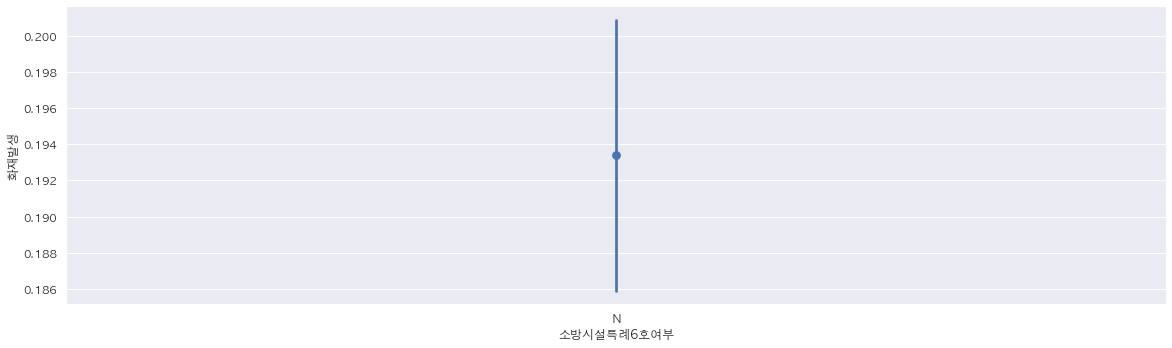

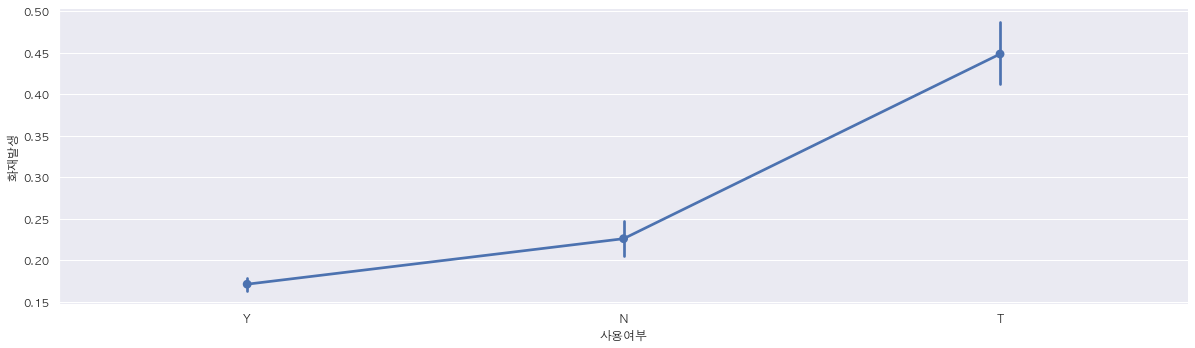

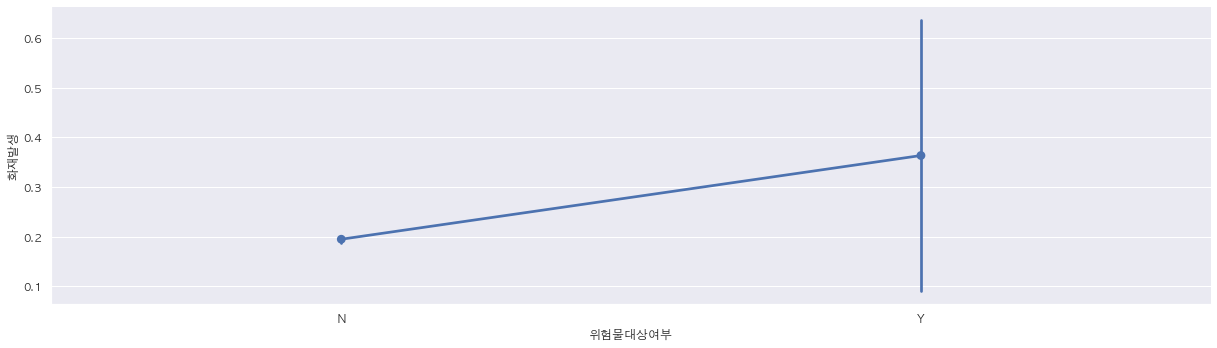

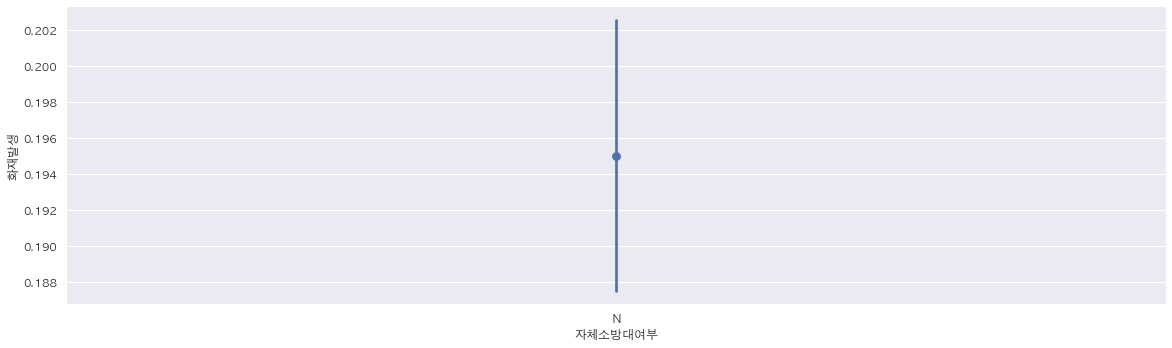

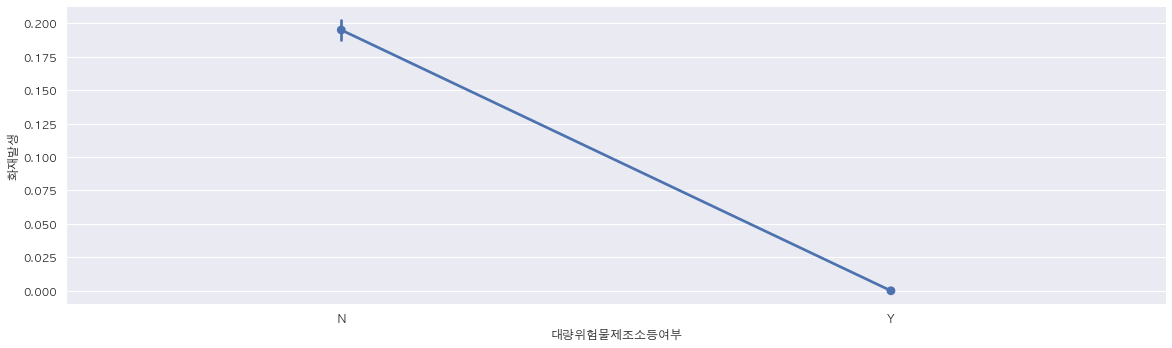

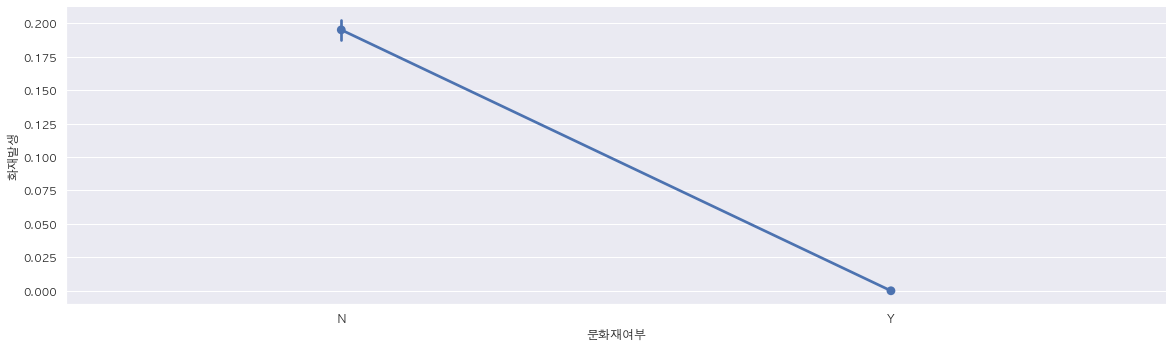

In [92]:
for col_name in object_col_names:
    g = sns.catplot(x=col_name, y="화재발생", kind="point", data=main_df);
    g.fig.set_figwidth(20)
    g.fig.set_figheight(5)

    

In [94]:

(main_df.isnull().sum() / len(main_df)).iplot(kind="bar")

# 왜 null 일까?
- null 코딩의 기준이 존재? 비슷한 수치를 보여주는건 비슷하지 않을까?
- "여부"는 binary value로 변환해보자


In [148]:
binary_col_names = object_col_names[-7:]
binary_col_names

['소방시설특례5호여부',
 '소방시설특례6호여부',
 '사용여부',
 '위험물대상여부',
 '자체소방대여부',
 '대량위험물제조소등여부',
 '문화재여부']

In [149]:
for col_name in binary_col_names:
    print(main_df[col_name].unique())

[nan 'N']
[nan 'N']
[nan 'Y' 'N' 'T']
[nan 'N' 'Y']
[nan 'N']
[nan 'N' 'Y']
[nan 'N' 'Y']


In [150]:
binary_col_names.remove("사용여부")

In [152]:
for col_name in binary_col_names:
    main_df[col_name] = main_df[col_name].replace({"Y":1 , "N":0})

In [157]:
for col_name in binary_col_names:
    corr_value = main_df[col_name].notnull().corr(main_df["화재발생"])
    print("{}: {}".format(col_name, corr_value))

소방시설특례5호여부: 0.0704379069634704
소방시설특례6호여부: 0.0704379069634704
위험물대상여부: 0.07889459621748915
자체소방대여부: 0.07889459621748915
대량위험물제조소등여부: 0.07889459621748915
문화재여부: 0.07889459621748915


In [161]:
for col_name in binary_col_names:
    corr_value = main_df[col_name].dropna().corr(main_df["화재발생"])
    print("{}: {}".format(col_name, corr_value))

소방시설특례5호여부: nan
소방시설특례6호여부: nan
위험물대상여부: 0.013383077618143018
자체소방대여부: nan
대량위험물제조소등여부: -0.004663400541539527
문화재여부: -0.004663400541539531


## findings
- 여부관련 친구들은 사용여부를 제외하고 모두 null 값 존재여부가 값 자체보다 훨씬 상관성을 가짐
- 해당 feature들은 drop 대신 null 값 여부는 두 항목을 남겨두면 좋을 듯

In [171]:
main_df_after_remove_binary = main_df.copy()
main_df_after_remove_binary["소방시설특례_null여부"] = main_df_after_remove_binary["소방시설특례5호여부"].isnull()
main_df_after_remove_binary["문화재_null여부"] = main_df_after_remove_binary["문화재여부"].isnull()
main_df_after_remove_binary = main_df_after_remove_binary.drop(binary_col_names, axis=1)

In [175]:
main_df_after_remove_binary["건물면적당가격"].notnull().corr(main_df["화재발생"])

-0.047041553242112635

In [176]:
main_df_after_remove_binary["건물면적당가격"].corr(main_df["화재발생"])

0.046735012764345295

In [178]:
main_df_after_remove_binary["강수량"].isnull().corr(main_df["화재발생"])

0.03577354629952626

In [180]:
main_df_after_remove_binary["강수량"].corr(main_df["화재발생"])

0.04477001661803374

In [181]:
main_df_after_remove_binary["건물구조"].notnull().corr(main_df["화재발생"])


0.34475643287817

In [183]:
main_df_after_remove_binary["건물용도"].notnull().corr(main_df["화재발생"])


0.3435167872278486

In [185]:
main_df_after_remove_binary["건물승인일자"].notnull().corr(main_df["화재발생"])


0.3459178727375037

In [186]:
main_df_after_remove_binary["건물용도분류명"].notnull().corr(main_df["화재발생"])

0.32080160893113285

## findings
- 건물용도, 건물승인일자등 몇몇의 각의 경우 null 여부가 높은 상관도를 지님 --> null 여부의 feature 추가

In [324]:
main_df_after_add_isnull = main_df_after_remove_binary.copy()
main_df_after_add_isnull["건물용도_isnull"] = main_df_after_remove_binary["건물용도"].isnull()
main_df_after_add_isnull["건물구조_isnull"] = main_df_after_remove_binary["건물구조"].isnull()
main_df_after_add_isnull["건물승인일자_isnull"] = main_df_after_remove_binary["건물승인일자"].isnull()
main_df_after_add_isnull["건물용도분류명_isnull"] = main_df_after_remove_binary["건물용도분류명"].isnull()

# 가설 - 화재발생 일자의 차이가 존재하는가?

In [325]:
main_df_after_add_isnull["화재발생월"] = main_df_after_add_isnull["dt_of_fr"].dt.month
main_df_after_add_isnull["화재발생년도"] = main_df_after_add_isnull["dt_of_fr"].dt.year
main_df_after_add_isnull["화재발생일"] = main_df_after_add_isnull["dt_of_fr"].dt.day
main_df_after_add_isnull["화재발생요일"] = main_df_after_add_isnull["dt_of_fr"].dt.weekday
main_df_after_add_isnull["화재발생시간"] = main_df_after_add_isnull["dt_of_fr"].dt.hour
main_df_after_add_isnull["화재발생주차"] = main_df_after_add_isnull["dt_of_fr"].dt.weekofyear


/Users/sungchulchoi/miniconda3/envs/python_ml/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [326]:
main_df_after_add_isnull.groupby("화재발생월")["화재발생"].mean().iplot(kind="bar")

In [327]:
main_df_after_add_isnull.groupby("화재발생일")["화재발생"].mean().iplot(kind="bar")

In [328]:
main_df_after_add_isnull.groupby("화재발생시간")["화재발생"].sum().iplot(kind="bar")

In [329]:
main_df_after_add_isnull.groupby("화재발생년도")["화재발생"].mean().iplot(kind="bar")

In [330]:
main_df_after_add_isnull.groupby("화재발생요일")["화재발생"].mean().iplot(kind="bar")

In [331]:
main_df_after_add_isnull.groupby("화재발생주차")["화재발생"].mean().iplot(kind="bar")

## findings
- 화재발생월은 계절적 요인이 있을 것으로 생각됨
- 화재발생요일은 크게 의미없는 것으로 판단됨
- 화재발생시간은 "오전", "일과중", "일과후" 로 나눌 수 있을 것으로 판단됨
- 화재발생주차도 의미 있으나 너무 복잡하여 제외

In [332]:
main_df_after_time_info = main_df_after_add_isnull.copy()

def change_month_to_season(month):
    if month in [1,2,3]:
        return "봄"
    if month in [4,5,6]:
        return "여름"
    if month in [7,8,9]:
        return "가을"
    if month in [10,11,12]:
        return "겨울"
main_df_after_time_info["계절"] = main_df_after_time_info["화재발생월"].map(change_month_to_season)

def change_hour_to_split(hour):
    if hour in range(0,8):
        return "split_1"
    if hour in range(11,20):
        return "split_2"
    if hour in range(20,25):
        return "split_3"
    return str(hour)
main_df_after_time_info["화재발생_구간"] = main_df_after_time_info["화재발생시간"].map(change_hour_to_split)
# main_df_after_time_info = main_df_after_time_info.drop(
#     ["dt_of_fr","화재발생주차", "화재발생요일","화재발생시간", "화재발생월"], axis=1)

In [333]:
main_df_after_time_info.head(1).T

0
dt_of_fr        2017-10-20 05:54:00
화재발생                              1
건물용도                           단독주택
건물구조                           블록구조
건물채수                              3
건물건축면적                        69.42
건물층별합계전체면적                    69.42
토지면적                              0
건물승인일자                         1977
건물들지상층수합                          1
건물들지하층수합                          0
건물용도분류명                         주거용
온도                             10.7
강수량                             NaN
풍속                              0.9
풍향                              200
습도                               96
지적상지목                             대
아이디                          106536
용도지역지구명                      자연녹지지역
용도지역지구명2                     지정되지않음
토지이용상황명                          단독
도로측면명                       세로한면(불)
행정구역명                  경상남도 창녕군 창녕읍
행정구역인구                        17360
소방서거리                          4547
건물면적당가격                         NaN
소방용수시설거리                        133
관할소방서인원                         137
다중이용시설여부                          N
공공CCTV거리                        112
백미터이내소방용수시설수                      0
백미터이내CCTV수                        0
담배소매점거리                        1891
안전비상벨최소거리                     29231
자동심장충격기거리                     11322
금연구역최소거리                         88
반경50m건물수                          0
소방점검대상물기준                       NaN
사용여부                            NaN
소방시설특례_null여부                  True
문화재_null여부                     True
건물용도_isnull                   False
건물구조_isnull                   False
건물승인일자_isnull                 False
건물용도분류명_isnull                False
화재발생월                            10
화재발생년도                         2017
화재발생일                            20
화재발생요일                            4
화재발생시간                            5
화재발생주차                           42
계절                               겨울
화재발생_구간                     split_1

# 가설 - 지역에 따른 차이는 존재하는가?

In [334]:
def get_sigungu(city_name):
    if isinstance(city_name, str):
        return city_name.split(" ")[1]
    return "NA"
def get_dongnae(city_name):
    if isinstance(city_name, str):
        return city_name[-1]
    return "NA"

main_df_after_time_info["시군구"] = main_df_after_time_info["행정구역명"].map(get_sigungu)
main_df_after_time_info["지역사이즈"] = main_df_after_time_info["행정구역명"].map(get_dongnae)

In [335]:
main_df_after_time_info.groupby("시군구")["화재발생"].mean().iplot(kind="bar")

In [336]:
main_df_after_time_info.groupby("지역사이즈")["화재발생"].mean().iplot(kind="bar")

## findings
- 지역사이즈가 "가" 인경우 빼기
- 창원시 모두 제거하기


In [381]:
main_df_after_location_info = main_df_after_time_info.copy()
main_df_after_location_info = main_df_after_location_info[
    ~main_df_after_location_info["시군구"].str.contains("창원")]

main_df_after_location_info = main_df_after_location_info[
    ~main_df_after_location_info["지역사이즈"].str.contains("가")]

# 가설 - 전력 사용량 데이터는 도움이 되는가?

In [377]:
gas_engry_df = all_df[gas_engry_col_names]
ele_engry_df = all_df[ele_engry_col_names]
lw_df = all_df[lw_col_names]

In [378]:
gas_engry_col_names = [col_name for col_name in all_df.columns.tolist() if "gas_engry_us" in col_name ]
ele_engry_col_names = [col_name for col_name in all_df.columns.tolist() if "ele_engry_us" in col_name ]
lw_col_names = [col_name for col_name in all_df.columns.tolist() if "lw" in col_name ]

In [379]:
gas_engry_df.isnull().T.sum().corr(main_df["화재발생"]
)

-0.3459178727375041

In [380]:
ele_engry_df.isnull().T.sum().corr(main_df["화재발생"]
)

-0.3459178727375041

In [342]:
lw_df.isnull().T.sum().corr(main_df["화재발생"]
)

-0.09955514078032876

## Findings
- 일단 null 인 이유가 화재발생가 상관이 있음
- null 인 경우에 대한 변수를 추가

In [343]:
main_df_after_engry = main_df_after_location_info.copy()
main_df_after_engry["gas_isnull"] = gas_engry_df.isnull().T.sum() > 1
main_df_after_engry["ele_isnull"] = ele_engry_df.isnull().T.sum() > 1
main_df_after_engry["lw_isnull"] = lw_df.isnull().T.sum() > 1

In [344]:
gas_engry_col_names = [col_name for col_name in all_df.columns.tolist() if "gas_engry_us" in col_name ]
ele_engry_col_names = [col_name for col_name in all_df.columns.tolist() if "ele_engry_us" in col_name ]
lw_col_names = [col_name for col_name in all_df.columns.tolist() if "lw" in col_name ]

<AxesSubplot:xlabel='date', ylabel='value'>

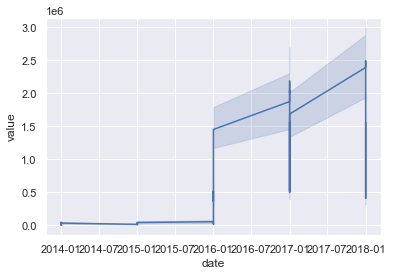

In [345]:
temp_df = gas_engry_df.dropna().reset_index().melt("index").rename(
    columns={"index":"id", "variable":"date"})
temp_df["date"] = temp_df["date"].map(lambda x : x.split("_")[-1])
temp_df["date"] = pd.to_datetime(temp_df["date"], format="%Y%M")
sns.lineplot(x="date", y="value", data=temp_df)

<AxesSubplot:xlabel='date', ylabel='value'>

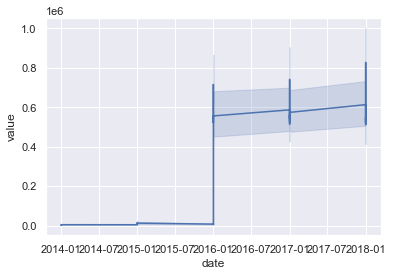

In [346]:
temp_df = ele_engry_df.dropna().reset_index().melt("index").rename(
    columns={"index":"id", "variable":"date"})
temp_df["date"] = temp_df["date"].map(lambda x : x.split("_")[-1])
temp_df["date"] = pd.to_datetime(temp_df["date"], format="%Y%M")
sns.lineplot(x="date", y="value", data=temp_df)

# 데이터 결측치 채우기

In [382]:
(main_df_after_engry.isnull().sum() / len(main_df_after_engry)).iplot(kind="bar")

In [383]:
main_df_after_engry.columns 

Index(['dt_of_fr', '화재발생', '건물용도', '건물구조', '건물채수', '건물건축면적', '건물층별합계전체면적',
       '토지면적', '건물승인일자', '건물들지상층수합', '건물들지하층수합', '건물용도분류명', '온도', '강수량', '풍속',
       '풍향', '습도', '지적상지목', '아이디', '용도지역지구명', '토지이용상황명', '도로측면명', '행정구역명',
       '행정구역인구', '소방서거리', '건물면적당가격', '소방용수시설거리', '관할소방서인원', '다중이용시설여부',
       '공공CCTV거리', '백미터이내소방용수시설수', '백미터이내CCTV수', '담배소매점거리', '안전비상벨최소거리',
       '자동심장충격기거리', '금연구역최소거리', '반경50m건물수', '소방점검대상물기준', '사용여부',
       '소방시설특례_null여부', '문화재_null여부', '건물용도_isnull', '건물구조_isnull',
       '건물승인일자_isnull', '건물용도분류명_isnull', '화재발생월', '화재발생년도', '화재발생일', '화재발생요일',
       '화재발생시간', '화재발생주차', '계절', '화재발생_구간', '시군구', '지역사이즈', 'gas_isnull',
       'ele_isnull', 'lw_isnull'],
      dtype='object')

In [488]:
clean_df = main_df_after_engry.copy()
clean_df["습도"] = clean_df.groupby(["행정구역명", "화재발생월", "화재발생일"])['습도'].transform('mean')
clean_df["습도"] = clean_df.groupby(["행정구역명", "화재발생월"])['습도'].transform('mean')
clean_df["습도"].fillna(clean_df["습도"].mean(), inplace=True)

clean_df["풍향"] = clean_df.groupby(["행정구역명", "화재발생월", "화재발생일"])['풍향'].transform('mean')
clean_df["풍향"] = clean_df.groupby(["행정구역명", "화재발생월"])['풍향'].transform('mean')
clean_df["풍향"].fillna(clean_df["풍향"].mean(), inplace=True)

clean_df["강수량"] = clean_df.groupby(["행정구역명", "화재발생월","화재발생일"])['강수량'].transform('mean')
clean_df["강수량"] = clean_df.groupby(["행정구역명", "화재발생월"])['강수량'].transform('mean')
clean_df["강수량"] = clean_df.groupby(["시군구", "화재발생월","화재발생일"])['강수량'].transform('mean')
clean_df["강수량"] = clean_df.groupby(["시군구", "화재발생월"])['강수량'].transform('mean')
clean_df["강수량"] = clean_df.groupby(["시군구"])['강수량'].transform('mean')
clean_df["강수량"].fillna(clean_df["강수량"].mean(), inplace=True)

clean_df["건물면적당가격"] = clean_df.groupby(["행정구역명"])['건물면적당가격'].transform('median')
clean_df["행정구역인구"] = clean_df.groupby(["행정구역명"])['행정구역인구'].transform('median')
clean_df["행정구역인구"] = clean_df.groupby(["시군구"])['행정구역인구'].transform('median')
clean_df["관할소방서인원"] = clean_df.groupby(["시군구"])['행정구역인구'].transform('median')


clean_df["풍속"].fillna(clean_df["풍속"].mean(), inplace=True)
clean_df["온도"].fillna(clean_df["온도"].mean(), inplace=True)
clean_df["건물면적당가격"].fillna(clean_df["건물면적당가격"].mean(), inplace=True)
clean_df["행정구역인구"].fillna(clean_df["행정구역인구"].mean(), inplace=True)
clean_df["관할소방서인원"].fillna(clean_df["관할소방서인원"].mean(), inplace=True)

clean_df['토지이용상황명'] = clean_df.groupby(['지적상지목'])['토지이용상황명'].transform(
    lambda x: x.fillna(Counter(x).most_common(1)[0][0]))
clean_df['도로측면명'] = clean_df.groupby(['지적상지목'])['도로측면명'].transform(
    lambda x: x.fillna(Counter(x).most_common(1)[0][0]))
clean_df['용도지역지구명'] = clean_df.groupby(['지적상지목'])['용도지역지구명'].transform(
    lambda x: x.fillna(Counter(x).most_common(1)[0][0]))
clean_df['토지이용상황명'] = clean_df['토지이용상황명'].transform(
    lambda x: x.fillna(Counter(x).most_common(1)[0][0]))
clean_df['도로측면명'] = clean_df['도로측면명'].transform(
    lambda x: x.fillna(Counter(x).most_common(1)[0][0]))
clean_df['용도지역지구명'] = clean_df['용도지역지구명'].transform(
    lambda x: x.fillna(Counter(x).most_common(1)[0][0]))

col_names = ['건물구조', '건물용도', '건물용도분류명',"사용여부"]
for col_name in col_names:
    clean_df[col_name] = clean_df[col_name].transform(
        lambda x: 'NA' if x is np.nan or "nan" else x)
    
clean_df["건물들지상층수합"] = clean_df['건물들지상층수합'].mode()[0]
clean_df["건물들지하층수합"] = clean_df['건물들지하층수합'].mode()[0]



In [489]:
(clean_df.isnull().sum() / len(clean_df)).iplot(kind="bar")

In [490]:
drop_cols = ["dt_of_fr", "건물승인일자", "아이디", "행정구역명","화재발생월", 
             "화재발생년도","화재발생일","화재발생요일","화재발생시간","화재발생주차","소방점검대상물기준"]
final_df = clean_df.copy()
final_df = final_df.drop(drop_cols, axis=1)
y = final_df.pop("화재발생")

one_hot_cols = ["건물용도", "건물구조","건물용도분류명","건물용도분류명","지적상지목","용도지역지구명","토지이용상황명","도로측면명","다중이용시설여부", 
                "계절", "화재발생_구간", "시군구", "지역사이즈","사용여부"]
one_hot_df = pd.get_dummies(final_df[one_hot_cols])
final_df = pd.merge(final_df, one_hot_df, left_index=True, right_index=True)
final_df = final_df.drop(one_hot_cols, axis=1)
X = final_df.copy()

In [491]:
(final_df.isnull().sum() / len(final_df)).iplot(kind="bar")

In [492]:
X.head(1).T

0
건물채수                     3
건물건축면적               69.42
건물층별합계전체면적           69.42
토지면적                     0
건물들지상층수합                 1
건물들지하층수합                 0
온도                    10.7
강수량                2.17561
풍속                     0.9
풍향                 110.238
습도                 71.3333
행정구역인구                3875
소방서거리                 4547
건물면적당가격             523888
소방용수시설거리               133
관할소방서인원               3875
공공CCTV거리               112
백미터이내소방용수시설수             0
백미터이내CCTV수               0
담배소매점거리               1891
안전비상벨최소거리            29231
자동심장충격기거리            11322
금연구역최소거리                88
반경50m건물수                 0
소방시설특례_null여부         True
문화재_null여부            True
건물용도_isnull          False
건물구조_isnull          False
건물승인일자_isnull        False
건물용도분류명_isnull       False
gas_isnull           False
ele_isnull           False
lw_isnull             True
건물용도_NA                  1
건물구조_NA                  1
건물용도분류명_NA               1
건물용도분류명_NA               1
지적상지목_공                  0
지적상지목_과                  0
지적상지목_구                  0
지적상지목_답                  0
지적상지목_대                  1
지적상지목_도                  0
지적상지목_목                  0
지적상지목_묘                  0
지적상지목_사                  0
지적상지목_수                  0
지적상지목_양                  0
지적상지목_원                  0
지적상지목_유                  0
지적상지목_임                  0
지적상지목_잡                  0
지적상지목_장                  0
지적상지목_전                  0
지적상지목_제                  0
지적상지목_종                  0
지적상지목_주                  0
지적상지목_차                  0
지적상지목_창                  0
지적상지목_천                  0
지적상지목_철                  0
지적상지목_체                  0
지적상지목_학                  0
용도지역지구명_개발제한구역           0
용도지역지구명_계획관리지역           0
용도지역지구명_관리지역             0
용도지역지구명_근린상업지역           0
용도지역지구명_농림지역             0
용도지역지구명_보전관리지역           0
용도지역지구명_보전녹지지역           0
용도지역지구명_생산관리지역           0
용도지역지구명_생산녹지지역           0
용도지역지구명_용도미지정            0
용도지역지구명_유통상업지역           0
용도지역지구명_일반공업지역           0
용도지역지구명_일반상업지역           0
용도지역지구명_자연녹지지역           1
용도지역지구명_자연환경보전지역         0
용도지역지구명_제1종일반주거지역        0
용도지역지구명_제1종전용주거지역        0
용도지역지구명_제2종일반주거지역        0
용도지역지구명_제2종전용주거지역        0
용도지역지구명_제3종일반주거지역        0
용도지역지구명_준공업지역            0
용도지역지구명_준주거지역            0
용도지역지구명_중심상업지역           0
토지이용상황명_경마장              0
토지이용상황명_고속도로휴게소          0
토지이용상황명_골프장 대중제          0
토지이용상황명_골프장 회원제          0
토지이용상황명_공업기타             0
토지이용상황명_공업나지             0
토지이용상황명_공업용              0
토지이용상황명_공원등              0
토지이용상황명_공원묘지             0
토지이용상황명_과수원              0
토지이용상황명_기타               0
토지이용상황명_다세대              0
토지이용상황명_단독               1
토지이용상황명_답                0
토지이용상황명_답기타              0
토지이용상황명_도로등              0
토지이용상황명_목장용지             0
토지이용상황명_발전소              0
토지이용상황명_상업기타             0
토지이용상황명_상업나지             0
토지이용상황명_상업용              0
토지이용상황명_스키장              0
토지이용상황명_아파트              0
토지이용상황명_업무용              0
토지이용상황명_여객자동차터미널         0
토지이용상황명_연립               0
토지이용상황명_운동장등             0
토지이용상황명_위험시설             0
토지이용상황명_유원지              0
토지이용상황명_유해.혐오시설          0
토지이용상황명_임야기타             0
토지이용상황명_자연림              0
토지이용상황명_전                0
토지이용상황명_전기타              0
토지이용상황명_조림               0
토지이용상황명_주거기타             0
토지이용상황명_주거나지             0
토지이용상황명_주상기타             0
토지이용상황명_주상나지             0
토지이용상황명_주상용              0
토지이용상황명_주차장등             0
토지이용상황명_콘도미니엄            0
토지이용상황명_토지임야             0
토지이용상황명_특수기타             0
토지이용상황명_하천등              0
도로측면명_광대로한면              0
도로측면명_광대세각               0
도로측면명_광대소각               0
도로측면명_맹지                 0
도로측면명_세로각지(가)            0
도로측면명_세로각지(불)            0
도로측면명_세로한면(가)            0
도로측면명_세로한면(불)            1
도로측면명_소로각지               0
도로측면명_소로한면               0
도로측면명_중로각지               0
도로측면명_중로한면               0
도로측면명_지정되지않음             0
다중이용시설여부_N               1
다중이용시설여부_Y               0
계절_가을                    0
계절_겨울                    1
계절

In [499]:
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777)

tree_model = RandomForestClassifier()
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)
y_true = y_test.copy()

f1_score(y_pred, y_true)

0.4063310845874416

In [501]:
params ={
    "n_estimators" : [10, 20, 30, 50, 100],
    "max_features" : [1,2,3,4,5,6,7, 10, 15, 20, 25]
    }
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=tree_model, param_grid=params, cv=5)
grid = grid.fit(X, y)

In [502]:
print("Best score : ", grid.best_score_)
print("Best parameter : ", grid.best_params_)

Best score :  0.8551903564304917
Best parameter :  {'max_features': 4, 'n_estimators': 100}


In [503]:
params ={
    "n_estimators" : [100, 150, 200],
    "max_features" : [1,2,3,4,5]
    }
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=tree_model, param_grid=params, cv=5)
grid = grid.fit(X, y)

print("Best score : ", grid.best_score_)
print("Best parameter : ", grid.best_params_)

Best score :  0.8562310293990114
Best parameter :  {'max_features': 1, 'n_estimators': 150}


In [514]:
pd.DataFrame(
    grid.best_estimator_.feature_importances_, index=X.columns).sort_values(by=0, ascending=False).iplot(kind="bar")